# Day Trading Algorithm
Prediction algorithm for stocks with daily returns from Close of current day
to Close the next day.

## Section 1: Data

### Create session for database interaction

In [93]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker

import urllib

Base = automap_base()

params = urllib.parse.quote_plus("DRIVER="
                                 "{ODBC Driver 17 for SQL Server};"
                                 "Server=tcp:"
                                 "xxxxxxxxxxxx.database.windows.net"
                                 ",xxxx;"  # Port
                                 "Database=xxxxxxx;"
                                 "Uid=xxxxxxxx;"
                                 "Pwd=xxxxxxxxxx;"
                                 "Encrypt=yes;"
                                 "TrustServerCertificate=no;"
                                 "Connection Timeout=30;")
engine = create_engine("mssql+pyodbc:///?odbc_connect={}"
                       .format(params))
Base.prepare(engine, reflect=True)
DBSession = sessionmaker(bind=engine)
session = DBSession()

### Define today in Date and Datetime format.

In [94]:
from datetime import date, datetime, timedelta, timezone

DATE_TODAY = date.today()
DATETIME_TODAY = datetime.today()

### Query data.

In [95]:
import pandas as pd

In [96]:
# Index historical prices sql string.
sql_index = '''SELECT index_prices.[date], index_prices.index_symbol,
index_prices.[close]
FROM index_prices
ORDER BY index_prices.[date];
'''

# Query database.
query_index = pd.read_sql(sql_index, con=engine)

# Set the date column as the dataframe index, and convert to standard UTC timezone.
query_index = query_index.set_index(['date']).tz_localize(tz='UTC')

In [97]:
# Ticker historical prices sql string.
sql_historical_prices = '''SELECT historical_prices.[date],
historical_prices.ticker_symbol,
historical_prices.[open],
historical_prices.[high],
historical_prices.[low],
historical_prices.[close],
historical_prices.[volume]
FROM historical_prices
ORDER BY historical_prices.[date];
'''

# Query database.
query_historical_prices = pd.read_sql(sql_historical_prices, con=engine)

# Set the date column as the dataframe index, and convert to standard UTC timezone.
query_historical_prices = query_historical_prices.set_index(['date']).tz_localize(tz='UTC')

In [98]:
# Ticker Earnings Per Share sql string.
sql_eps = '''SELECT eps_report_date, ticker_symbol, actual_eps, consensus_eps
FROM earnings
ORDER BY ticker_symbol, eps_report_date;
'''

# Query database
query_eps = pd.read_sql(sql_eps, con=engine)

# Set the eps_report_date colume as the dataframe index, and convert to standard UTC timezone.
query_eps = query_eps.set_index(['eps_report_date']).tz_localize(tz='UTC')

In [99]:
# Report Date Per Company sql string.
sql_report_date = "SELECT * FROM dbo.report_date ORDER BY [date];"

# Query database
query_report_date = pd.read_sql(sql_report_date, con=engine)

# Set the date column as the dataframe index, and convert to standard UTC timezone.
query_report_date = query_report_date.set_index(['date']).tz_localize(tz='UTC')

### Format data.

In [100]:
import numpy as np

In [101]:
# Open
open_prices = query_historical_prices.reset_index().pivot(index='date',
                                                          columns='ticker_symbol',
                                                          values='open')

In [102]:
# High
high_prices = query_historical_prices.reset_index().pivot(index='date',
                                                          columns='ticker_symbol',
                                                          values='high')

In [103]:
# Low
low_prices = query_historical_prices.reset_index().pivot(index='date',
                                                          columns='ticker_symbol',
                                                          values='low')

In [104]:
# Close
close_prices = query_historical_prices.reset_index().pivot(index='date',
                                                          columns='ticker_symbol',
                                                          values='close')

In [105]:
# Volume
volume = query_historical_prices.reset_index().pivot(index='date',
                                                          columns='ticker_symbol',
                                                          values='volume')

In [106]:
# Actual EPS
actual_eps = query_eps.reset_index().pivot(index='eps_report_date',
                                           columns='ticker_symbol',
                                           values='actual_eps')
actual_eps_ffill = actual_eps.replace(0, np.nan).ffill()

In [107]:
# Consensus EPS
consensus_eps = query_eps.reset_index().pivot(index='eps_report_date',
                                              columns='ticker_symbol',
                                              values='consensus_eps')
consensus_eps_ffill = consensus_eps.replace(0, np.nan).ffill()

In [108]:
# Report Date
report_date = query_report_date.reset_index().pivot(index='date',
                                                    columns='ticker_symbol',
                                                    values='id')

## Section 2: Alpha Model

### Format factors.

In [109]:
def my_zscore(x, axis=0, ddof=0):
    mean = x.mean(axis=axis)
    std = x.std(axis=axis, ddof=ddof)
    return (x - mean) / std

In [110]:
# Intra-day returns
returns = ((close_prices / close_prices.shift(1)) - 1)

In [111]:
# One Year Momentum
one_year_momemtum = ((close_prices / close_prices.shift(252)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [112]:
# Mean Reversion 5 Day
mean_reversion_5_day = -((close_prices / close_prices.shift(5)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [113]:
# Average Dollar Volume 5 Day
ave_dol_vol = volume * close_prices
ave_dol_vol_mean = ave_dol_vol.rolling(5).mean()
ave_dol_vol_5d_mean = ((ave_dol_vol_mean / ave_dol_vol_mean.shift(1)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [114]:
# Returns EMA(8)
ema_8 = returns.ewm(com=7, min_periods=8).mean()
ema_8_mean = ((ema_8 / ema_8.shift(1)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [115]:
# Returns EMA(8)
ema_8 = close_prices.ewm(com=20, min_periods=21).mean()
ema_8_return = ((ema_8 / ema_8.shift(1)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [116]:
# Returns EMA(21)
ema_21 = close_prices.ewm(com=20, min_periods=21).mean()
ema_21_return = ((ema_21 / ema_21.shift(1)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [117]:
# Returns EMA(50)
ema_50 = close_prices.ewm(com=20, min_periods=21).mean()
ema_50_return = ((ema_50 / ema_50.shift(1)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [118]:
# Relative Strength Index
rsi_period = 14

rsi_returns = ((close_prices / close_prices.shift(1)) - 1)
gain = rsi_returns.mask(rsi_returns < 0, 0)
loss = rsi_returns.mask(rsi_returns > 0, 0)

ewm_gain = gain.ewm(com=rsi_period - 1, min_periods=rsi_period).mean()
ewm_loss = loss.ewm(com=rsi_period - 1, min_periods=rsi_period).mean()

rs = abs(ewm_gain) / abs(ewm_loss)

rsi = 100 - (100/(1 + rs))

rsi_14 = ((rsi / rsi.shift(1)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [119]:
# Relative Strength Index
# RSI > 95
# RSI < 5
rsi_g_95 = (rsi > 95).astype(int)
rsi_l_5 = (rsi < 5).astype(int)

In [120]:
# Average True Range
w = abs(high_prices - low_prices)
x = abs(high_prices - close_prices.shift(1))
y = abs(low_prices - close_prices.shift(1))
z = pd.concat([w, x, y]).groupby(level=0).max()
atr = z.ewm(com=13, min_periods=14).mean()

In [121]:
# Bollinger Bands
sma = close_prices.rolling(window=20).mean()
rstd = close_prices.rolling(window=20).std()

upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd

# Close Price > Upper Band
close_g_upper_boll_band = (close_prices > upper_band).astype(int)

# Close Price < Lower Band
close_l_lower_boll_band = (close_prices < lower_band).astype(int)

In [122]:
# Stochastic Oscillator
stoch_osc = pd.DataFrame()
C = close_prices
L = low_prices.rolling(14).min()
H = high_prices.rolling(14).max()
# K Line = Number of Periods
K = ((C - L) / (H - L)) * 100
# D Line = Moving Average of K Line
D = K.ewm(com=2, min_periods=3).mean()
stoch_osc['K'] = K.stack()
stoch_osc['D'] = D.stack()

# If < 20 = Oversold and Indicates Long Buying Signal
# If > 20 = Overbought and Indicates Long Selling Signal
# If K > D AND K < 80 = Long Buy Signal

In [123]:
# MACD
macdf = pd.DataFrame()
fast = close_prices.ewm(com=11, min_periods=12).mean()
slow = close_prices.ewm(com=25, min_periods=26).mean()
macd = fast - slow
signal = macd.ewm(com=8, min_periods=9).mean()
macdf['macd'] = macd.stack()
macdf['signal'] = signal.stack()

# MACD > Signal

In [124]:
# Stochastic Oscillator + MACD
# Long Buy Signals Within 2 Days of Each Other

In [125]:
# Volume Oscillator
fast = volume.rolling(window=5).mean()
slow = volume.rolling(window=20).mean()
osc = fast - slow
vol_osc_5_20 = ((osc - osc.shift(1)) - 1).\
    rank(axis='columns').\
    apply(my_zscore, axis='columns').\
    fillna(0)

In [126]:
# Report Date
reporting_fill = report_date.fillna(0)
reporting = (reporting_fill > 0).astype(int)

### Format pipeline

In [185]:
factors = pd.DataFrame()
factors['ema_8'] = ema_8_return.stack()
factors['ema_21'] = ema_21_return.stack()
factors['ema_50'] = ema_50_return.stack()
factors['one_year_momentum'] = one_year_momemtum.stack()
factors['mean_reversion_5_day'] = mean_reversion_5_day.stack()
factors['ave_dol_vol_5d_mean'] = -ave_dol_vol_5d_mean.stack()
factors['ema_8_mean'] = ema_8_mean.stack()
factors['rsi_14'] = rsi_14.stack()
factors['atr'] = atr.stack()
factors['vol_osc_5_20'] = vol_osc_5_20.stack()

### Format Features

In [186]:
factors['rsi_g_95'] = rsi_g_95.stack()
factors['rsi_l_5'] = rsi_l_5.stack()
factors['close_g_upper_boll_band'] = close_g_upper_boll_band.stack()
factors['close_l_lower_boll_band'] = close_l_lower_boll_band.stack()
factors['stoch_osc'] = (
    ((stoch_osc['K'] > stoch_osc['D']).astype(int) == 1) &
    ((stoch_osc['K'] < 80.0).astype(int) == 1)
).astype(int)
factors['macd'] = (
    ((macdf['macd'] > macdf['signal']).astype(int) == 1)
)
factors['stoch_osc_and_macd'] = (
    ((factors['stoch_osc'] == 1) & (factors['macd'] == 1)) |
    ((factors['stoch_osc'].shift(1) == 1) & (factors['macd'].shift(1) == 1)) |
    ((factors['stoch_osc'] == 1) & (factors['macd'].shift(1) == 1)) |
    ((factors['stoch_osc'].shift(1) == 1) & (factors['macd'] == 1))
).astype(int)
factors['is_reporting'] = reporting.stack()
factors['is_January'] = (factors.index.get_level_values(0).month == 1).astype(int)
factors['is_December'] = (factors.index.get_level_values(0).month == 12).astype(int)
factors['weekday'] = (factors.index.get_level_values(0).weekday).astype(int)
factors['quarter'] = (factors.index.get_level_values(0).quarter).astype(int)
factors['month_end'] = (factors.index.get_level_values(0).isin(pd.date_range(start=min(factors.index.get_level_values(0)), end=max(factors.index.get_level_values(0)), freq='BM'))).astype(int)
factors['month_start'] = (factors.index.get_level_values(0).isin(pd.date_range(start=min(factors.index.get_level_values(0)), end=max(factors.index.get_level_values(0)), freq='BMS'))).astype(int)
factors['qtr_end'] = (factors.index.get_level_values(0).isin(pd.date_range(start=min(factors.index.get_level_values(0)), end=max(factors.index.get_level_values(0)), freq='BQ'))).astype(int)
factors['qtr_start'] = (factors.index.get_level_values(0).isin(pd.date_range(start=min(factors.index.get_level_values(0)), end=max(factors.index.get_level_values(0)), freq='BQS'))).astype(int)

### Format Target

In [187]:
target = (returns >= 0.01).astype(int).shift(-1)
factors['target'] = target.stack()

### All Factors.

In [188]:
factors

ema_8    ema_21    ema_50  \
date                      ticker_symbol                                 
2019-01-02 00:00:00+00:00 A              0.000000  0.000000  0.000000   
                          AAL            0.000000  0.000000  0.000000   
                          AAP            0.000000  0.000000  0.000000   
                          AAPL           0.000000  0.000000  0.000000   
                          ABBV           0.000000  0.000000  0.000000   
...                                           ...       ...       ...   
2020-08-05 00:00:00+00:00 YUM           -0.597140 -0.597140 -0.597140   
                          ZBH            0.219999  0.219999  0.219999   
                          ZBRA           1.232692  1.232692  1.232692   
                          ZION          -0.862535 -0.862535 -0.862535   
                          ZTS            1.428246  1.428246  1.428246   

                                         one_year_momentum  \
date                      ticker_symbol                      
2019-01-02 00:00:00+00:00 A                       0.000000   
                          AAL                     0.000000   
                          AAP                     0.000000   
                          AAPL                    0.000000   
                          ABBV                    0.000000   
...                                                    ...   
2020-08-05 00:00:00+00:00 YUM                    -0.890471   
                          ZBH                    -0.101269   
                          ZBRA                    1.295549   
                          ZION                   -0.883487   
                          ZTS                     1.065074   

                                         mean_reversion_5_day  \
date                      ticker_symbol                         
2019-01-02 00:00:00+00:00 A                         -0.000000   
                          AAL                       -0.000000   
                          AAP                       -0.000000   
                          AAPL                      -0.000000   
                          ABBV                      -0.000000   
...                                                       ...   
2020-08-05 00:00:00+00:00 YUM                        1.393326   
                          ZBH                        1.407294   
                          ZBRA                      -1.421262   
                          ZION                       0.485394   
                          ZTS                       -1.533008   

                                         ave_dol_vol_5d_mean  ema_8_mean  \
date                      ticker_symbol                                    
2019-01-02 00:00:00+00:00 A                        -0.000000    0.000000   
                          AAL                      -0.000000    0.000000   
                          AAP                      -0.000000    0.000000   
                          AAPL                     -0.000000    0.000000   
                          ABBV                     -0.000000    0.000000   
...                                                      ...         ...   
2020-08-05 00:00:00+00:00 YUM                       1.512055   -1.204756   
                          ZBH                      -0.003492   -1.281581   
                          ZBRA                      1.260628    0.869519   
                          ZION                      0.925392   -1.225708   
                          ZTS                      -1.079042    0.701901   

                                           rsi_14       atr  vol_osc_5_20  \
date                      ticker_symbol                                     
2019-01-02 00:00:00+00:00 A              0.000000       NaN      0.000000   
                          AAL            0.000000       NaN      0.000000   
                          AAP            0.000000       NaN      0.000000   
                          AAPL           0.000000       NaN      0.

### Evaluate Alpha Factors

In [189]:
import alphalens as al

In [190]:
assets = factors.index.levels[1].values.tolist()

In [191]:
temp = factors.replace([np.inf, -np.inf], np.nan).fillna(0).copy()

In [192]:
X = temp.drop(labels='target', axis=1)
y = temp['target']

In [193]:
evaluate_factors = factors.loc[X.index.levels[0][252]:]

clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=close_prices, periods=[1])
    for factor, factor_data in evaluate_factors[['one_year_momentum','mean_reversion_5_day','ave_dol_vol_5d_mean','rsi_14','vol_osc_5_20']].iteritems()
}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


### Quantile Analysis

<AxesSubplot:xlabel='date'>

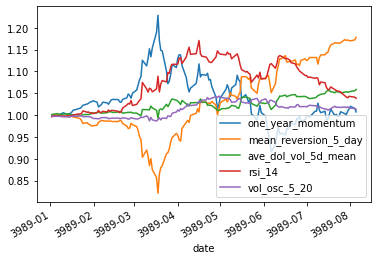

In [194]:
# Factor Returns
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

array([[<AxesSubplot:title={'center':'one_year_momentum'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'mean_reversion_5_day'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'ave_dol_vol_5d_mean'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'rsi_14'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'vol_osc_5_20'}, xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>]], dtype=object)

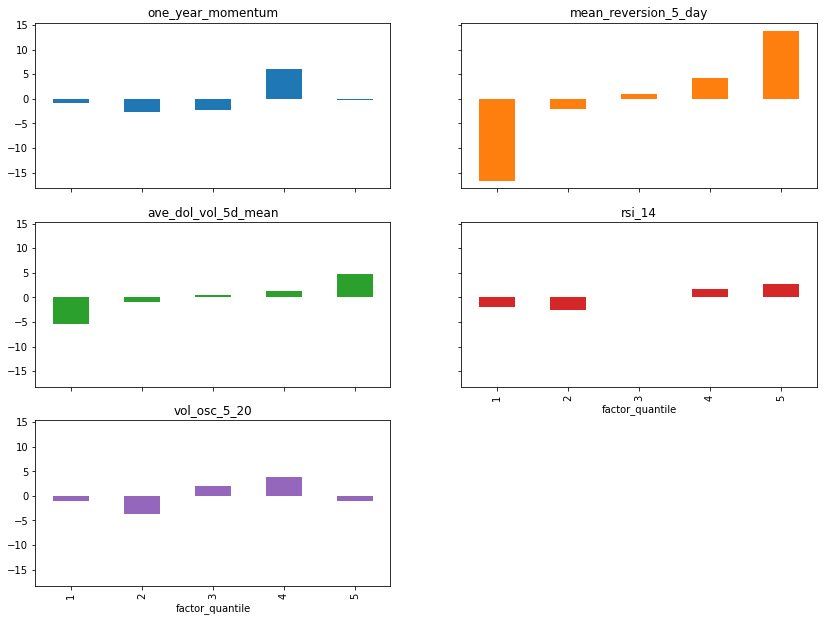

In [195]:
# Basis Points Per Quantile Per Day
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

<AxesSubplot:title={'center':'Factor Rank Autocorrelation'}, xlabel='date'>

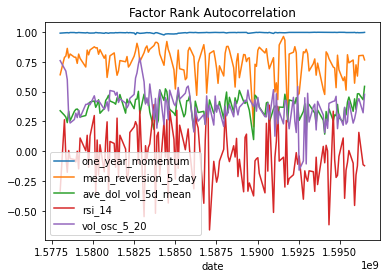

In [196]:
# Turnover Analysis
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [197]:
def sharpe_ratio(factor_returns, annualization_factor):
    sharpe = annualization_factor*factor_returns.mean()/factor_returns.std()
    return sharpe

In [198]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio_list = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)
sharpe_ratio_list

one_year_momentum       0.17
mean_reversion_5_day    1.54
ave_dol_vol_5d_mean     1.39
rsi_14                  0.55
vol_osc_5_20            0.48
dtype: float64

### Format predictions.

In [199]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    x_train_idx, x_valid_idx, x_test_idx = np.split(all_x.index.levels[0], [int(train_size*len(all_x.index.levels[0])), int((train_size+valid_size)*len(all_x.index.levels[0]))])
    y_train_idx, y_valid_idx, y_test_idx = np.split(all_y.index.levels[0], [int(train_size*len(all_y.index.levels[0])), int((train_size+valid_size)*len(all_y.index.levels[0]))])
    
    x_train = all_x.loc[x_train_idx[0]:x_train_idx[-1]]
    x_valid = all_x.loc[x_valid_idx[0]:x_valid_idx[-1]]
    x_test = all_x.loc[x_test_idx[0]:x_test_idx[-1]]
    y_train = all_y.loc[y_train_idx[0]:y_train_idx[-1]]
    y_valid = all_y.loc[y_valid_idx[0]:y_valid_idx[-1]]
    y_test = all_y.loc[y_test_idx[0]:y_test_idx[-1]]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [200]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

### Prediction model.

In [201]:
from sklearn.tree import DecisionTreeClassifier

In [202]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=20)

In [203]:
# Set variables for index dates
start = X.index.levels[0][0]
stop = X.index.levels[0][-2]
two_days_ago = X.index.levels[0][-2]
last = X.index.levels[0][-1]
print("Start: {}\nStop: {}\nTwo Days Ago: {}\nLast: {}".format(start, stop, two_days_ago, last))

Start: 2019-01-02 00:00:00+00:00
Stop: 2020-08-04 00:00:00+00:00
Two Days Ago: 2020-08-04 00:00:00+00:00
Last: 2020-08-05 00:00:00+00:00


In [204]:
# Fit X and y data
clf.fit(X.loc[start:stop], y.loc[start:stop])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [205]:
# Each factor with percentage of importance score.
importances = clf.feature_importances_
count = 0
for perc in importances:
    print("{} : {}".format(X.columns[count], round(perc, 4)))
    count += 1

ema_8 : 0.0379
ema_21 : 0.0373
ema_50 : 0.0352
one_year_momentum : 0.0745
mean_reversion_5_day : 0.1192
ave_dol_vol_5d_mean : 0.0979
ema_8_mean : 0.1191
rsi_14 : 0.1032
atr : 0.1082
vol_osc_5_20 : 0.0837
rsi_g_95 : 0.0002
rsi_l_5 : 0.0
close_g_upper_boll_band : 0.0034
close_l_lower_boll_band : 0.0083
stoch_osc : 0.0148
macd : 0.0152
stoch_osc_and_macd : 0.0098
is_reporting : 0.0001
is_January : 0.0108
is_December : 0.0035
weekday : 0.0493
quarter : 0.0335
month_end : 0.0165
month_start : 0.0072
qtr_end : 0.0078
qtr_start : 0.0034


### Train, Validate and Test predictions.

In [206]:
# Accuracy score for training data.
train_score = clf.score(X_train, y_train)

# Accuracy score for validation data.
valid_score = clf.score(X_valid, y_valid)

# Accurancy score for test data.
test_score = clf.score(X_test, y_test)

print("Training Accuracy: {} \nValidation Accuracy: {} \nTesting Accuracy: {}".\
    format(train_score, valid_score, test_score))

Training Accuracy: 0.8420224869495382 
Validation Accuracy: 0.9374243951612903 
Testing Accuracy: 0.8680057745917961


### Make predictions for yesterday.

In [207]:
# Prediction for last date in test data. This should be prior day.
p = clf.predict(X_test.loc[last:])
p

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1.

### Format predictions dataframe

In [208]:
def show_sample_results(data, samples, classifier):
    # Calculate the Prediction and Alpha Score for sample.
    prob_array=[-1, 1]
    prediction = classifier.predict(samples)
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Prediction and Alpha Score to dataframe.
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha['PREDICTION'] = prediction
    factors_with_alpha['AI_ALPHA'] = alpha_score
    return factors_with_alpha

In [209]:
# Create new dataframe to pass into Risk Assessment section.
df_prediction_alpha = show_sample_results(X.loc[start:], X_test.loc[last:], clf)

# Add Prediction and AI_Alpha columns.
prediction_alpha = df_prediction_alpha[['is_reporting','PREDICTION','AI_ALPHA']]

# Filter on stocks NOT reporting today.
not_reporting_alpha = prediction_alpha[prediction_alpha['is_reporting']==0].copy()

# Filter on Long predictions only.
long_alpha = not_reporting_alpha[not_reporting_alpha['PREDICTION']==1].copy()

# Create new alpha dataframe, and Drop PREDICTION column
alpha = pd.DataFrame()
alpha = long_alpha.drop(labels=['is_reporting','PREDICTION'], axis=1).copy()

In [210]:
alpha

AI_ALPHA
date                      ticker_symbol          
2020-08-05 00:00:00+00:00 AAL                 1.0
                          ABBV                1.0
                          ADI                 1.0
                          AIV                 0.6
                          AIZ                 1.0
...                                           ...
                          WHR                 1.0
                          WMB                 1.0
                          WMT                 1.0
                          ZBH                 1.0
                          ZTS                 1.0

[96 rows x 1 columns]

## Section 3: Risk Model

### Format returns for risk model

In [211]:
# Create new dataframe for risk model.
returns_risk_model = pd.DataFrame()

# Add returns data.
returns_risk_model = returns.iloc[:-1].copy()

# Create list of alpha dataframe tickers.
alpha_tickers = []
for idx, value in alpha.iterrows():
    alpha_tickers.append(idx[1])

# Return only columns that are from alpha dataframe.
risk_model = returns_risk_model[alpha_tickers]

In [212]:
# Calculate mean returns for each ticker.
m = risk_model.mean()

In [213]:
# Demean the returns
risk_model_demean = risk_model - m

In [214]:
# Replace any (inf, nan) with 0
rets= risk_model_demean.replace([np.inf, -np.inf], np.nan).fillna(0).copy()

### Principal Component Analysis (PCA) Risk Model

In [215]:
from sklearn.decomposition import PCA

class RiskModelPCA():
    ANN_FACTOR = 252

    def __init__(self, num_factors):
        self._num_factors = num_factors
        self.num_stocks_ = None
        self.factor_betas_ = None
        self.factor_returns_ = None
        self.common_returns_ = None
        self.residuals_ = None
        self.factor_cov_matrix_ = None
        self.idio_var_matrix_ = None
        self.explained_variance_ratio_ = None

    def fit(self, returns):
        self.num_stocks_ = len(returns.columns)
        mod = PCA(n_components=self._num_factors,
                  svd_solver='full')
        mod.fit(returns)
        
        self.factor_betas_ = pd.DataFrame(
            data=mod.components_.T,
            index=returns.columns
        )
        
        self.factor_returns_ = pd.DataFrame(
            data=mod.transform(rets),
            index=returns.index
        )
        
        self.explained_variance_ratio_ = (
            mod.explained_variance_ratio_
        )
        
        self.common_returns_ = pd.DataFrame(
            data=np.dot(self.factor_returns_,
            self.factor_betas_.T
            ),
            index=returns.index
        )

        self.common_returns_.columns = returns.columns
        
        self.residuals_ = (returns - self.common_returns_)
        
        self.factor_cov_matrix_ = np.diag(
            self.factor_returns_.
            var(axis=0, ddof=1) * RiskModelPCA.ANN_FACTOR
        )
        
        self.idio_var_matrix_ = pd.DataFrame(
            data=np.diag(np.var(self.residuals_)) * RiskModelPCA.ANN_FACTOR,
            index=returns.columns
        )
        
        self.idio_var_vector_ = pd.DataFrame(
            data=np.diag(self.idio_var_matrix_.values),
            index=returns.columns
        )
        
        self.idio_var_matrix_.columns = returns.columns

    def get_factor_exposures(self, weights):
        B = self.factor_betas_.loc[weights.index]
        return B.T.dot(weights)

In [216]:
# Set count of Principal Components
pc_count = min(20, len(rets.columns))
pc_count

20

In [217]:
# Instantiate RiskMoelPCA Class above.
rm = RiskModelPCA(pc_count)

In [218]:
# Call fit function, and pass in rets
rm.fit(rets)

In [219]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '% of Variance Explained by Each Principal Component')

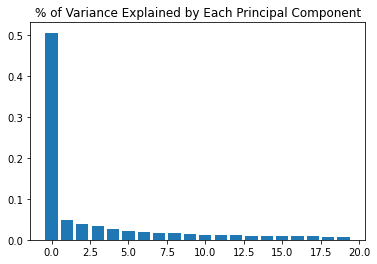

In [220]:
# Plot Risk Model explained variance ratios by Principal Component.
plt.bar(np.arange(pc_count),
        rm.explained_variance_ratio_
)
plt.title("% of Variance Explained by Each Principal Component")

## Section 4: Portfolio Optimization

### Create Optimization Constraints

* Risk, based on our risk model
* Leverage
* Market Neutral
* Factor Exposure Limits
* Individual Weight Limits

### Risk

In [221]:
# Factor Betas from Risk Model
B = rm.factor_betas_

In [222]:
# Factor Covariance Matrix
F = rm.factor_cov_matrix_

In [223]:
# Idiosyncratic Variance Vector
S = np.diag(rm.idio_var_vector_.values.flatten())

In [224]:
# Risk Function
def risk_fcn(x):
    f = np.dot(
        B.values.T,
        x
    )
    return np.dot(f.T, np.dot(F, f)) + np.dot(x, np.dot(S, x))

### Leverage

In [225]:
# Leverage Function
def lev_fcn(x):
    return np.abs(x[0]) + np.abs(x[1]) + np.abs(x[2])

### Market Neutral

In [226]:
# Market Neutral Function
def mn_fcn(x):
    return sum(x)

### Factor Exposures

In [227]:
# Factor Exposure Function
def fac_fcn(x):
    return np.dot(B.values.T, x)

### Weight Limits

In [228]:
x_max = 0.55

### Optimization

In [229]:
import cvxpy as cvx

In [230]:
# Optimization Function
def find_optimal_holdings(
    alpha_vector,
    risk_model,
    risk_cap=0.1,
    factor_max=0.015,
    factor_min=-0.015,
    x_max=0.02,
    x_min=-0.02,
    lambda_reg=0.5):

    # Factor Betas
    B = risk_model.factor_betas_

    # Factor Covariance Matrix
    F = risk_model.factor_cov_matrix_

    # Idiosyncratic Variance Matrix
    S = np.diag(risk_model.idio_var_vector_.values.flatten())

    # Weights
    x = cvx.Variable(len(alpha_vector))

    # Factor Exposures
    f = B.values.T * x

    # Risk Function
    risk = cvx.quad_form(f, F) + cvx.quad_form(x, S)

    # Objective Function
    obj = cvx.Maximize((alpha_vector.values.flatten() * x) - (lambda_reg * cvx.norm(x,2)))

    # Constraints
    cons = [
        sum(cvx.abs(x)) <= 1.0, # Sum of absolute value of all weights must be less than or equal to 1.0
        sum(x) == 0.0, # Sum of all weights must equal 0.0
        #x >= 0, # All weights must be greater than or equal to 0 for a Long Only portfolio
        x <= x_max, # Maximum weight must be less than or equal to x_max
        x >= x_min, # Minimum weight must be greater than or equal to x_min
        risk <= risk_cap, # Total risk must be less than or equal to risk_cap
        f <= factor_max, # Factor exposure must be less than or equal to factor_max
        f >= factor_min # Factor exposre must be greater than or equal to factor_min 
    ]

    # Problem Function
    prob = cvx.Problem(obj, cons)

    # Problem Solver
    prob.solve(verbose=True, max_iters=500)

    # Optimal Weights
    optimal_weights = np.asarray(x.value).flatten()

    # Return optimal weights as a dataframe
    return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

### Optimal Weights

In [231]:
# Format alpha dataframe into series vector
alpha_vector = alpha['AI_ALPHA']

In [232]:
optimal_weights = find_optimal_holdings(alpha_vector, rm)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.121e-20  -6.932e+00  +2e+04  1e+00  1e+00  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -3.737e+00  -4.828e+00  +4e+03  1e-01  5e-01  9e-02  2e-01  0.8837  1e-01   2  2  2 |  0  0
 2  -5.221e-01  -5.740e-01  +3e+03  2e-02  2e-02  2e-01  2e-01  0.5161  6e-01   3  2  3 |  0  0
 3  -3.372e-01  -3.402e-01  +9e+02  4e-03  5e-03  5e-02  5e-02  0.7162  5e-03   2  1  1 |  0  0
 4  -2.906e-01  -3.068e-01  +6e+02  2e-03  3e-03  2e-02  3e-02  0.5953  4e-01   2  2  2 |  0  0
 5  -2.612e-01  -2.718e-01  +2e+02  8e-04  9e-04  4e-04  1e-02  0.9890  3e-01   2  2  2 |  0  0
 6  -2.373e-01  -2.407e-01  +7e+01  3e-04  3e-04  1e-04  3e-03  0.7605  1e-01   3  3  3 |  0  0
 7  -2.321e-01  -2.341e-01  +4e+01  1e-04  2e-04  5e-05  2e-03  0.6305  3e-01   3  3  3 |  0  0
 8  -2.266e-01  -2.272e-01  +1e+01  4e-05  4e-

In [233]:
# Rename optimal_weights dataframe column name
optimal_weights_renamed = optimal_weights.rename({0: 'weights'}, axis=1)

In [234]:
optimal_weights_sorted = optimal_weights_renamed.sort_values(by=['weights'], ascending=False)
optimal_weights_sorted

weights
date                      ticker_symbol          
2020-08-05 00:00:00+00:00 ARNC           0.005974
                          ADI            0.005722
                          FTI            0.005621
                          VNO            0.005613
                          LYB            0.005574
...                                           ...
                          WDC           -0.020000
                          DISCK         -0.020000
                          DISCA         -0.020000
                          AIV           -0.020000
                          OMC           -0.020000

[96 rows x 1 columns]

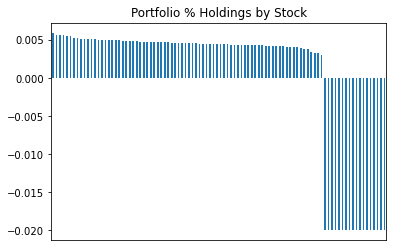

In [235]:
optimal_weights_sorted.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [236]:
ratios = optimal_weights_sorted.head(20)

In [237]:
total = 0
for r, values in ratios.iterrows():
    total += values

In [238]:
percentages = []
for r, values in ratios.iterrows():
    perc = values / total
    percentages.append(perc)

In [239]:
allocation = []
for p in percentages:
    allocation.append(p * 10000.0)

In [240]:
investment_today = pd.DataFrame(index=ratios.index, data=allocation)
investment_today

weights
date                      ticker_symbol            
2020-08-05 00:00:00+00:00 ARNC           567.665769
                          ADI            543.741190
                          FTI            534.110212
                          VNO            533.388423
                          LYB            529.636181
                          DXC            521.544925
                          REG            500.563805
                          UA             499.469731
                          DISH           494.896459
                          NOV            489.345535
                          STT            486.887588
                          COF            484.301635
                          INTC           483.600806
                          HBAN           481.257841
                          IRM            479.725574
                          GPS            477.610736
                          CDW            475.319133
                          AIZ            472.425915
                          HSIC           472.378253
                          VTR            472.130285

In [241]:
investment_today['weights'].sum()

10000.000000000002

In [242]:
investments_today = optimal_weights_sorted.loc[optimal_weights_sorted['weights'] > 0]
for i in investments_today.iterrows():
    print(i[0][1])

ARNC
ADI
FTI
VNO
LYB
DXC
REG
UA
DISH
NOV
STT
COF
INTC
HBAN
IRM
GPS
CDW
AIZ
HSIC
VTR
MLM
IPG
CMCSA
DIS
MYL
WMT
SYY
PKG
HPE
HPQ
REGN
COO
BF.B
O
FIS
LIN
F
FBHS
MGM
NLSN
PEP
CL
ANET
EXPD
CINF
TAP
CERN
CHRW
SO
LKQ
PXD
NEM
LNT
HII
WAT
ALK
BAX
WHR
ZBH
JCI
BMY
WMB
JNJ
PKI
J
ABBV
LDOS
ZTS
GIS
HFC
DHI
ROL
AAL
PHM
APA
LB
COTY
NLOK
